In [51]:
from keras.applications.vgg16 import VGG16

from keras.preprocessing import image

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from data import ImageDataset
from features import VggFeaturize
from preprocess import VggPreprocess

In [62]:
root_dir = './dataset/' # change this to relevant directory

# load pre-trained VGG16 model; remove top fc and softmax layers
model = VGG16(weights='imagenet', include_top=False)

# load and preprocess image data
preprocess = VggPreprocess()
image_dataset = ImageDataset(root_dir=root_dir, image_size=(224, 224), 
                            preprocess=preprocess)

# load pre-trained VGG16 model; remove top fc and softmax layers
model = VGG16(weights='imagenet', include_top=False)

# extract features from image data
featurize = VggFeaturize(model=model)
X = []
for sample in image_dataset:
    X.append(featurize(sample))

X = np.array(X)
X.shape

(998, 25088)

In [63]:
# run PCA on extracted feature and reduce dimension; project to 50 dimensions
pca = PCA(n_components=50)
X_r = pca.fit_transform(X)
X_r.shape

(998, 50)

In [64]:
# % of variance explained for each of the first five components
pca.explained_variance_ratio_[:5]

array([0.04332353, 0.03148356, 0.02194322, 0.01166103, 0.01089679],
      dtype=float32)

In [65]:
# perform k-means clustering
# compute sum of squared distances for range of values of k
sse = []
ks = list(range(2, 10))
for k in ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
    kmeans.fit(X_r)
    sse.append(kmeans.inertia_)

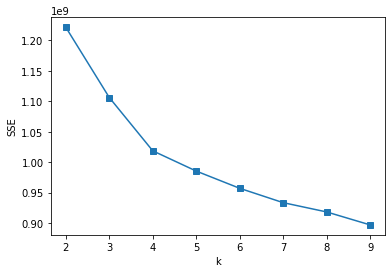

In [66]:
# plot SSE against number of clusters k;
# note the "elbow" or "knee", which indicates optimal number of clusters
plt.plot(ks, sse, 's-')
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

In [67]:
# perform k-means clustering using the optimal k based on the "elbow" above
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
kmeans.fit(X_r)

KMeans(n_clusters=4, random_state=0)

In [68]:
# store our cluster/label predictions
y = kmeans.labels_
y.shape

(998,)

Text(0, 0.5, 'PCA Component 2')

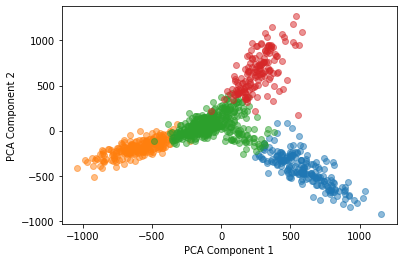

In [69]:
for k in range(n_clusters):
    plt.scatter(X_r[y == k, 0], X_r[y == k, 1], label=k, alpha=.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

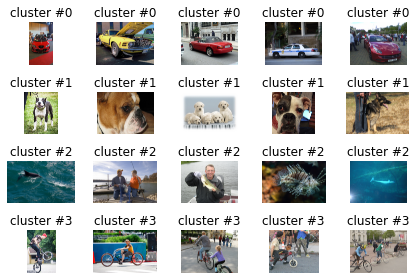

In [70]:
fig, axs = plt.subplots(n_clusters, 5)
for k in range(n_clusters):
    indexes = np.where(y == k)[0][:5]
    for i, index in enumerate(indexes):
        axs[k, i].imshow(image.load_img(image_dataset[index]['filename']))
        axs[k, i].set_title('cluster #{}'.format(k))
        axs[k, i].axis('off')
plt.tight_layout()